
# Seasonal Biogeochemical Model using CO2SYS in Python

This notebook replicates a biogeochemical box model originally implemented in R. It uses Python along with the [CO2SYS](https://pypi.org/project/pyco2sys/) toolbox for carbonate chemistry calculations. The model simulates the seasonal variability of temperature, salinity, DIC, TA, pCO₂, and pH in surface and deep ocean layers.

## Directory Structure
- `img/`: Saved plots
- `data/raw/`: Raw input data
- `data/interim/`: Intermediate results
- `data/processed/`: Final outputs (CSV, NetCDF, etc.)


In [1]:
# directories
rawDir = "../data/raw/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"
imgDir = "../img/"

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from pathlib import Path
import PyCO2SYS as pyco2
import xarray as xr

sns.set(style="whitegrid")

In [3]:

# Model parameters
params = {
    'tau_1T': 0.14, 'tau_1S': 0.11, 
    'tau_2': 0.19,
    'A_1T': 14.48, 'A_1S': -1.46, 'A_2T': 5.21,
    'phi_1T': -0.63, 'phi_1S': np.pi / 4, 'phi_2T': np.pi / 2,
    'T1_star': 15, 'T2_star': 10,
    'S1_star': 35, 'S2_star': 34,
    'h1': 50, 'h2': 100,
    'KD': 0.1, 'NCP': 0.02, 'PICPOC': 0.04, 'Remin': 0.9, # Biological parameters
    'K_air': 0.02, 'alpha_CO2': 0.01, 'pCO2_atm': 423.57
}

# Initial state variables: [T1, T2, S1, S2, DIC1, DIC2, TA1, TA2]
state0 = [15, 10, 35, 34, 2000, 2100, 2300, 2400]

# Time points (daily over 10 years)
times = np.arange(0, 365 * 10, 10)



In [ ]:

def model(state, t, p):
    T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state
    
    seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t / 365 + p['phi_1T'])
    seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t / 365 + p['phi_2T'])
    seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t / 365 + p['phi_1S'])

    dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T']
    dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2T']
    dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S']
    dS2 = (p['S2_star'] - S2) / p['tau_2']

  
    # --- Mixing step based on potential density ---
    rho1 = density(T1_hat, S1_hat)
    rho2 = density(T2_hat, S2_hat)

    if rho1 > rho2: #If rho1 > rho2 → surface water is heavier, mixing occurs.
        mix_T = (p['h1'] * T1_hat + p['h2'] * T2_hat) / (p['h1'] + p['h2'])
        mix_S = (p['h1'] * S1_hat + p['h2'] * S2_hat) / (p['h1'] + p['h2'])
        T1 = T2 = mix_T
        S1 = S2 = mix_S

        # Now recalculate updated dT/dS based on final values (possibly mixed)
        dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T']
        dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2T']
        dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S']
        dS2 = (p['S2_star'] - S2) / p['tau_2']

    J_air = 0  # placeholder – real J_air is added later using pyco2sys

    dDIC1 = (J_air + p['KD'] * (DIC2 - DIC1)  - p['NCP'] * (1 + p['PICPOC'])) / p['h1']
    dDIC2 = (p['Remin'] * p['NCP'] * (1 + p['PICPOC']) - p['KD'] * (DIC2 - DIC1) )/ p['h2']
    dTA1 = (p['KD'] * (TA2 - TA1)- 2 * p['NCP'] * p['PICPOC']) / p['h1']
    dTA2 = (-p['KD'] * (TA2 - TA1)  + 2 * p['NCP'] * p['PICPOC']) / p['h2']

    

    return [dT1, dT2, dS1, dS2, dDIC1, dDIC2, dTA1, dTA2]


In [5]:

output = odeint(model, state0, times, args=(params,))
output_df = pd.DataFrame(output, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
output_df['time'] = times

In [6]:
print(output_df.head())

          T1         T2         S1    S2         DIC1         DIC2  \
0  15.000000  10.000000  35.000000  34.0  2000.000000  2100.000000   
1   2.026920  10.875639  35.842536  34.0  2001.966197  2099.016693   
2   1.116933  11.742435  35.625841  34.0  2003.874281  2098.062444   
3   0.617327  12.557725  35.390645  34.0  2005.725968  2097.136392   
4   0.542869  13.297409  35.143902  34.0  2007.522925  2096.237705   

           TA1          TA2  time  
0  2300.000000  2400.000000     0  
1  2301.969983  2399.015009    10  
2  2303.881743  2398.059128    20  
3  2305.737003  2397.131499    30  
4  2307.537431  2396.231284    40  


In [7]:
# Loop through each time step to calculate carbonate chemistry
for i in range(len(output_df)):
    try:
        # --- Surface carbonate chemistry ---
        res_surface = pyco2.sys(
            par1=output_df.loc[i, 'TA1'], # already in μmol·kg⁻¹
            par2=output_df.loc[i, 'DIC1'], # already in μmol·kg⁻¹
            par1_type=1,  # TA
            par2_type=2,  # DIC
            salinity=output_df.loc[i, 'S1'],
            temperature=output_df.loc[i, 'T1'],
            pressure=1,
            opt_pH_scale=1
        )

        pCO2_surface = res_surface['pCO2']
        output_df.loc[i, 'pH_surface'] = res_surface['pH_total']
        output_df.loc[i, 'pCO2_surface'] = pCO2_surface

        # --- J_air calculation ---
        J_air = params['K_air'] * params['alpha_CO2'] * (params['pCO2_atm'] - pCO2_surface)
        output_df.loc[i, 'J_air'] = J_air

        # --- Recalculate dDIC1 using actual J_air ---
        DIC1 = output_df.loc[i, 'DIC1']
        DIC2 = output_df.loc[i, 'DIC2']

        dDIC1_recalc = (J_air + params['KD'] * (DIC2 - DIC1) / params['h1']- params['NCP'] * (1 + params['PICPOC'])) / params['h1']
        output_df.loc[i, 'dDIC1_recalc'] = dDIC1_recalc

        dDIC2_recalc = (params['Remin'] * params['NCP'] * (1 + params['PICPOC'])- params['KD'] * (DIC2 - DIC1) / params['h2']) / params['h2']
        output_df.loc[i, 'dDIC2_recalc'] = dDIC2_recalc


        # --- Deep carbonate chemistry ---
        res_deep = pyco2.sys(
            par1=output_df.loc[i, 'TA2'],
            par2=output_df.loc[i, 'DIC2'],
            par1_type=1,
            par2_type=2,
            salinity=output_df.loc[i, 'S2'],
            temperature=output_df.loc[i, 'T2'],
            pressure=100,
            opt_pH_scale=1
        )
        output_df.loc[i, 'pH_deep'] = res_deep['pH_total']
        output_df.loc[i, 'pCO2_deep'] = res_deep['pCO2']

    except Exception as e:
        print(f"Error on row {i}: {e}")
        continue

# Save updated output
output_df.to_csv(processedDir + "output_df_with_co2sys2.csv", index=False)

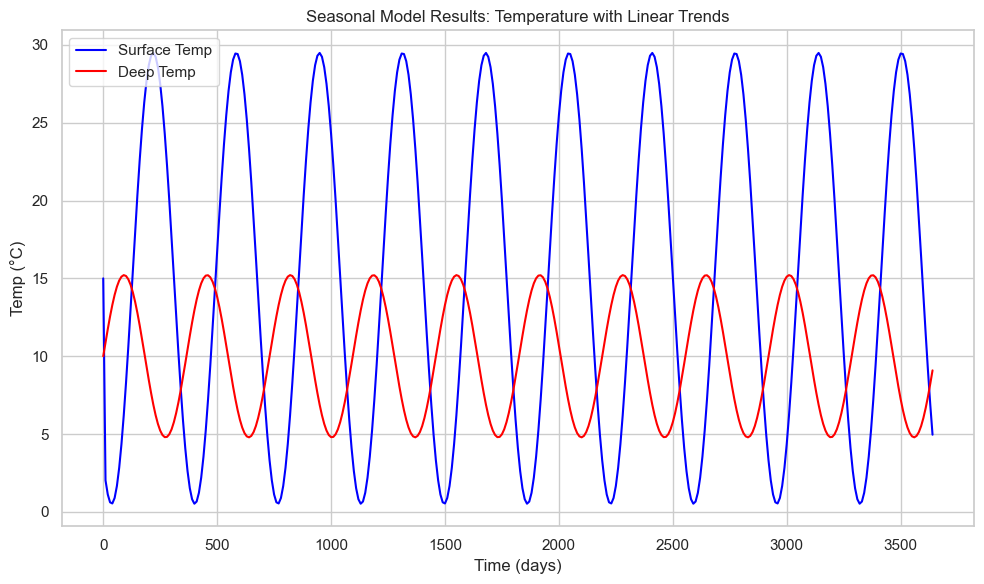

In [8]:
# Plot original temperature data
plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['T1'], label='Surface Temp', color='blue')
plt.plot(output_df['time'], output_df['T2'], label='Deep Temp', color='red')

# Labels and styling
plt.xlabel("Time (days)")
plt.ylabel("Temp (°C)")
plt.title("Seasonal Model Results: Temperature with Linear Trends")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "temperature_plot2.png", dpi=300)
plt.show()


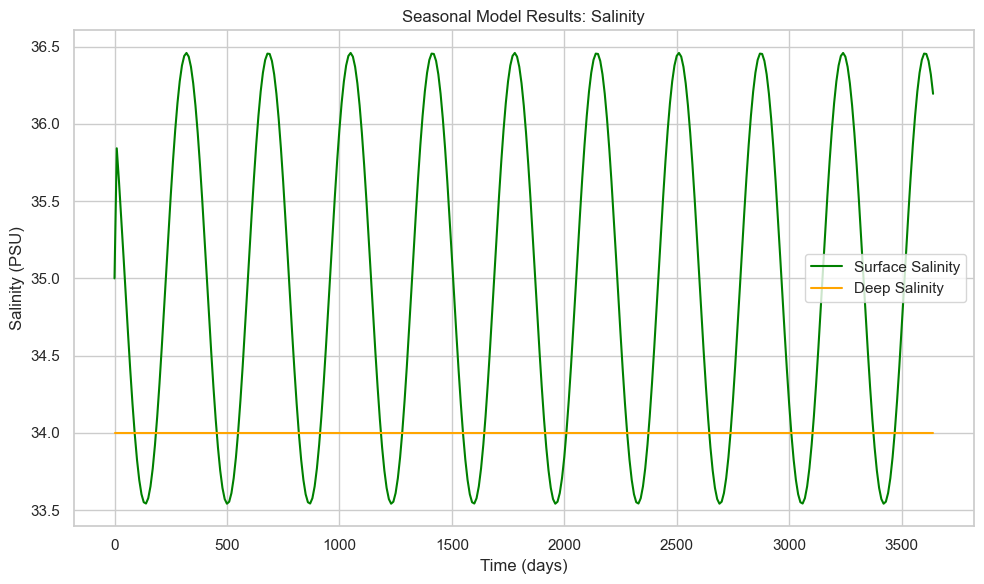

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['S1'], label='Surface Salinity', color='green')
plt.plot(output_df['time'], output_df['S2'], label='Deep Salinity', color='orange')
plt.xlabel("Time (days)")
plt.ylabel("Salinity (PSU)")
plt.title("Seasonal Model Results: Salinity")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "salinity_plot2.png", dpi=300)
plt.show()


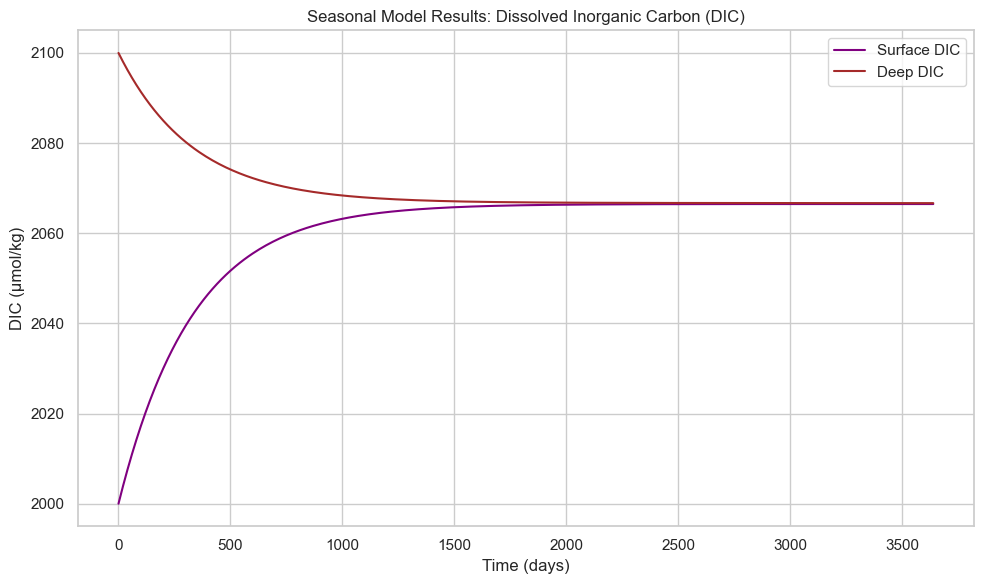

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['DIC1'], label='Surface DIC', color='purple')
plt.plot(output_df['time'], output_df['DIC2'], label='Deep DIC', color='brown')
plt.xlabel("Time (days)")
plt.ylabel("DIC (μmol/kg)")
plt.title("Seasonal Model Results: Dissolved Inorganic Carbon (DIC)")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "dic_plot2.png", dpi=300)
plt.show()


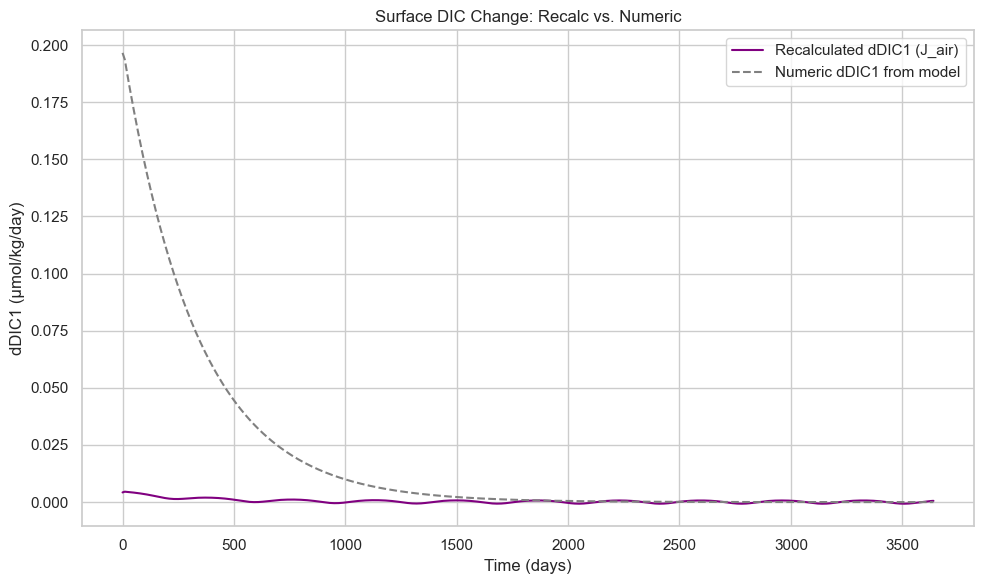

In [11]:
output_df['dDIC1_numeric'] = np.gradient(output_df['DIC1'], output_df['time'])

plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['dDIC1_recalc'], label='Recalculated dDIC1 (J_air)', color='purple')
plt.plot(output_df['time'], output_df['dDIC1_numeric'], label='Numeric dDIC1 from model', linestyle='--', color='gray')
plt.xlabel('Time (days)')
plt.ylabel('dDIC1 (µmol/kg/day)')
plt.title('Surface DIC Change: Recalc vs. Numeric')
plt.legend()
plt.tight_layout()
plt.show()


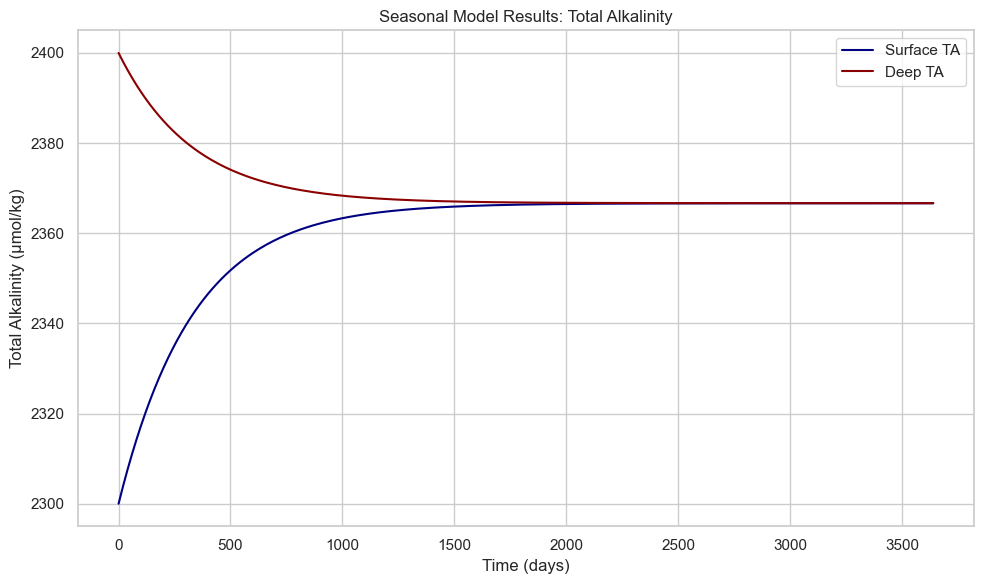

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['TA1'], label='Surface TA', color='navy')
plt.plot(output_df['time'], output_df['TA2'], label='Deep TA', color='darkred')
plt.xlabel("Time (days)")
plt.ylabel("Total Alkalinity (μmol/kg)")
plt.title("Seasonal Model Results: Total Alkalinity")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "alkalinity_plot2.png", dpi=300)
plt.show()


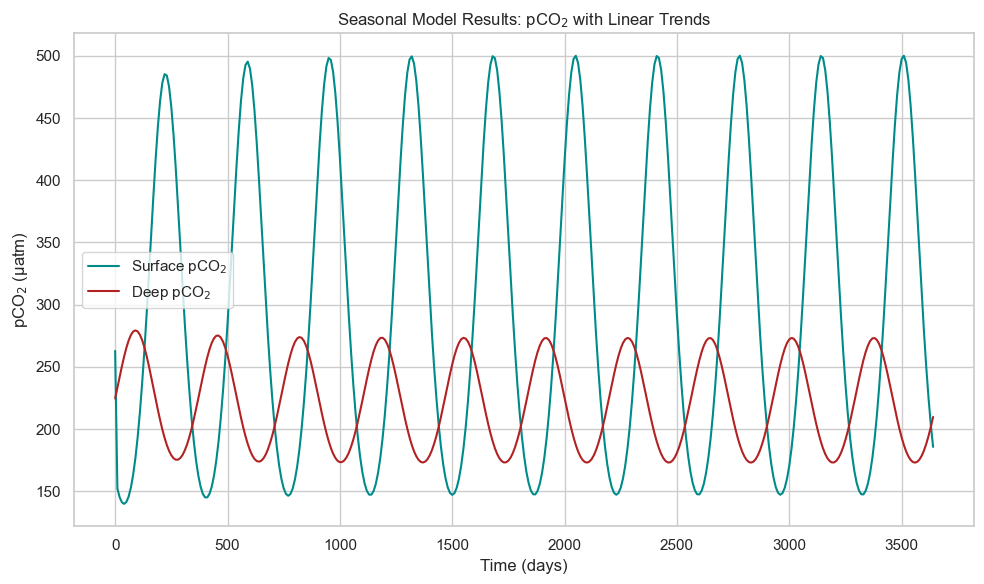

In [13]:
# Plot original data
plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['pCO2_surface'], label='Surface pCO$_2$', color='darkcyan')
plt.plot(output_df['time'], output_df['pCO2_deep'], label='Deep pCO$_2$', color='firebrick')

# Labels and styling
plt.xlabel("Time (days)")
plt.ylabel("pCO$_2$ (µatm)")
plt.title("Seasonal Model Results: pCO$_2$ with Linear Trends")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "pco2_plot2.png", dpi=300)
plt.show()

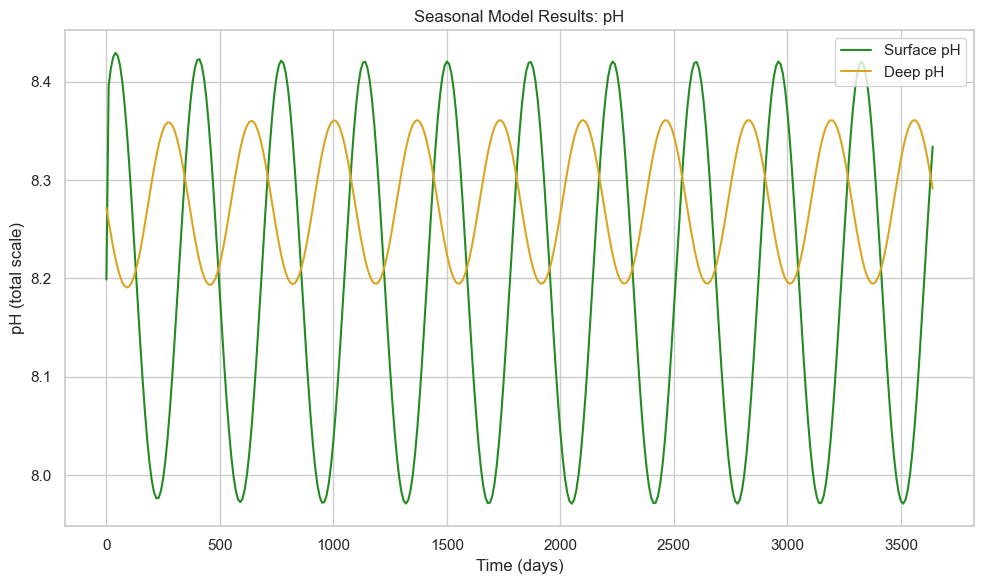

In [14]:

plt.figure(figsize=(10, 6))
plt.plot(output_df['time'], output_df['pH_surface'], label='Surface pH', color='forestgreen')
plt.plot(output_df['time'], output_df['pH_deep'], label='Deep pH', color='goldenrod')

# Labels and styling
plt.xlabel("Time (days)")
plt.ylabel("pH (total scale)")
plt.title("Seasonal Model Results: pH")
plt.legend()
plt.tight_layout()
plt.savefig(imgDir + "ph_plot2.png", dpi=300)
plt.show()


In [15]:

def model_oneway(state, t, p):
    T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state
    
    seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t / 365 + p['phi_1T'])
    seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t / 365 + p['phi_2T'])
    seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t / 365 + p['phi_1S'])

    dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T']
    dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2']
    dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S']
    dS2 = (p['S2_star'] - S2) / p['tau_2']

    J_air = 0  # placeholder – real J_air is added later using pyco2sys

    dDIC1 = (J_air + p['KD'] * (DIC2 - DIC1)  - p['NCP'] * (1 + p['PICPOC'])) / p['h1']
    #dDIC1 = (p['K_air'] * p['alpha_CO2'] * (p['pCO2_atm'] - DIC1) + p['KD'] * (DIC2 - DIC1) / p['h1'] - p['NCP'] * (1 + p['PICPOC'])) / p['h1']
    dDIC2 = (p['Remin'] * p['NCP'] * (1 + p['PICPOC']) - p['KD'] * (DIC2 - DIC1)) / p['h2']
    dTA1 = (p['KD'] * (TA2 - TA1) - 2 * p['NCP'] * p['PICPOC']) / p['h1']
    dTA2 = (-p['KD'] * (TA2 - TA1) + 2 * p['NCP'] * p['PICPOC']) / p['h2']

    # --- Mixing step based on potential density ---
    # Simplified density approximation: ρ ≈ ρ₀ - α(T - T₀) + β(S - S₀)
    # We'll use constants: α = 0.2, β = 0.8 (approx), ρ₀ = 1025 kg/m³
    alpha = 0.2 # For every degree increase in T, density decreases by ~0.2
    beta = 0.8 # For every unit increase in S, density increases by ~0.8
    rho1 = 1025 - alpha * (T1 - 10) + beta * (S1 - 35)
    rho2 = 1025 - alpha * (T2 - 10) + beta * (S2 - 35)

    if rho1 > rho2: #If rho1 > rho2 → surface water is heavier, mixing occurs.
        h1 = p['h1']
        h2 = p['h2']
        mix_T = (h1 * T1 + h2 * T2) / (h1 + h2)
        mix_S = (h1 * S1 + h2 * S2) / (h1 + h2)
        T1 = T2 = mix_T
        S1 = S2 = mix_S
        #DIC1 = DIC2 = (h1 * DIC1 + h2 * DIC2) / (h1 + h2)
        #TA1 = TA2 = (h1 * TA1 + h2 * TA2) / (h1 + h2)

    return [dT1, dT2, dS1, dS2, dDIC1, dDIC2, dTA1, dTA2]


In [16]:
# Run model
output_1 = odeint(model_oneway, state0, times, args=(params,))
output_df_1 = pd.DataFrame(output_1, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
output_df_1['time'] = times

In [17]:
pCO2_surface, pH_surface = [], []
pCO2_deep, pH_deep = [], []
J_air_list = []

for i in range(len(output_df_1)):
    # --- Surface ---
    res_surface = pyco2.sys(
        par1=output_df_1.loc[i, 'TA1'],
        par2=output_df_1.loc[i, 'DIC1'],
        par1_type=1, par2_type=2,
        salinity=output_df_1.loc[i, 'S1'],
        temperature=output_df_1.loc[i, 'T1'],
        pressure=1,
        opt_pH_scale=1
    )
    pCO2_surf = res_surface['pCO2']
    pH_surf = res_surface['pH_total']
    J_air = params['K_air'] * params['alpha_CO2'] * (params['pCO2_atm'] - pCO2_surf)

    # --- Deep ---
    res_deep = pyco2.sys(
        par1=output_df_1.loc[i, 'TA2'],
        par2=output_df_1.loc[i, 'DIC2'],
        par1_type=1, par2_type=2,
        salinity=output_df_1.loc[i, 'S2'],
        temperature=output_df_1.loc[i, 'T2'],
        pressure=100,
        opt_pH_scale=1
    )
    pCO2_d = res_deep['pCO2']
    pH_d = res_deep['pH_total']

    # Store results
    pCO2_surface.append(pCO2_surf)
    pH_surface.append(pH_surf)
    J_air_list.append(J_air)
    pCO2_deep.append(pCO2_d)
    pH_deep.append(pH_d)

output_df_1['pCO2_surface'] = pCO2_surface
output_df_1['pH_surface'] = pH_surface
output_df_1['J_air'] = J_air_list
output_df_1['pCO2_deep'] = pCO2_deep
output_df_1['pH_deep'] = pH_deep


In [18]:
J_air_interp = interp1d(output_df_1['time'], output_df_1['J_air'], kind='linear', fill_value='extrapolate')

In [19]:
def model_feedback(state, t, p):
    T1, T2, S1, S2, DIC1, DIC2, TA1, TA2 = state
    J_air = J_air_interp(t)

    seasonal_T1 = p['A_1T'] * np.cos(2 * np.pi * t / 365 + p['phi_1T'])
    seasonal_T2 = p['A_2T'] * np.cos(2 * np.pi * t / 365 + p['phi_2T'])
    seasonal_S1 = p['A_1S'] * np.cos(2 * np.pi * t / 365 + p['phi_1S'])

    dT1 = (p['T1_star'] - seasonal_T1 - T1) / p['tau_1T']
    dT2 = (p['T2_star'] - seasonal_T2 - T2) / p['tau_2']
    dS1 = (p['S1_star'] - seasonal_S1 - S1) / p['tau_1S']
    dS2 = (p['S2_star'] - S2) / p['tau_2']

    dDIC1 = (J_air + p['KD'] * (DIC2 - DIC1)  - p['NCP'] * (1 + p['PICPOC'])) / p['h1']
    dDIC2 = (p['Remin'] * p['NCP'] * (1 + p['PICPOC']) - p['KD'] * (DIC2 - DIC1) ) / p['h2']
    dTA1 = (p['KD'] * (TA2 - TA1) - 2 * p['NCP'] * p['PICPOC']) / p['h1']
    dTA2 = (-p['KD'] * (TA2 - TA1) + 2 * p['NCP'] * p['PICPOC']) / p['h2']

    return [dT1, dT2, dS1, dS2, dDIC1, dDIC2, dTA1, dTA2]


In [20]:
output_2 = odeint(model_feedback, state0, times, args=(params,))
output_df_2 = pd.DataFrame(output_2, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
output_df_2['time'] = times


In [21]:
pCO2_surf_final, pH_surf_final = [], []
pCO2_deep_final, pH_deep_final = [], []

for i in range(len(output_df_2)):
    # --- Surface ---
    res_surface = pyco2.sys(
        par1=output_df_2.loc[i, 'TA1'],
        par2=output_df_2.loc[i, 'DIC1'],
        par1_type=1, par2_type=2,
        salinity=output_df_2.loc[i, 'S1'],
        temperature=output_df_2.loc[i, 'T1'],
        pressure=1,
        opt_pH_scale=1
    )
    pCO2_surf_final.append(res_surface['pCO2'])
    pH_surf_final.append(res_surface['pH_total'])

    # --- Deep ---
    res_deep = pyco2.sys(
        par1=output_df_2.loc[i, 'TA2'],
        par2=output_df_2.loc[i, 'DIC2'],
        par1_type=1, par2_type=2,
        salinity=output_df_2.loc[i, 'S2'],
        temperature=output_df_2.loc[i, 'T2'],
        pressure=100,
        opt_pH_scale=1
    )
    pCO2_deep_final.append(res_deep['pCO2'])
    pH_deep_final.append(res_deep['pH_total'])

# Store in DataFrame
output_df_2['pCO2_surface'] = pCO2_surf_final
output_df_2['pH_surface'] = pH_surf_final
output_df_2['pCO2_deep'] = pCO2_deep_final
output_df_2['pH_deep'] = pH_deep_final


In [22]:
# Merge on 'time', adding suffixes to distinguish runs
merged_df = output_df_1.merge(
    output_df_2,
    on='time',
    suffixes=('_run1', '_run2')
)
# Save to CSV
merged_df.to_csv(processedDir + "merged_model_runs.csv", index=False)

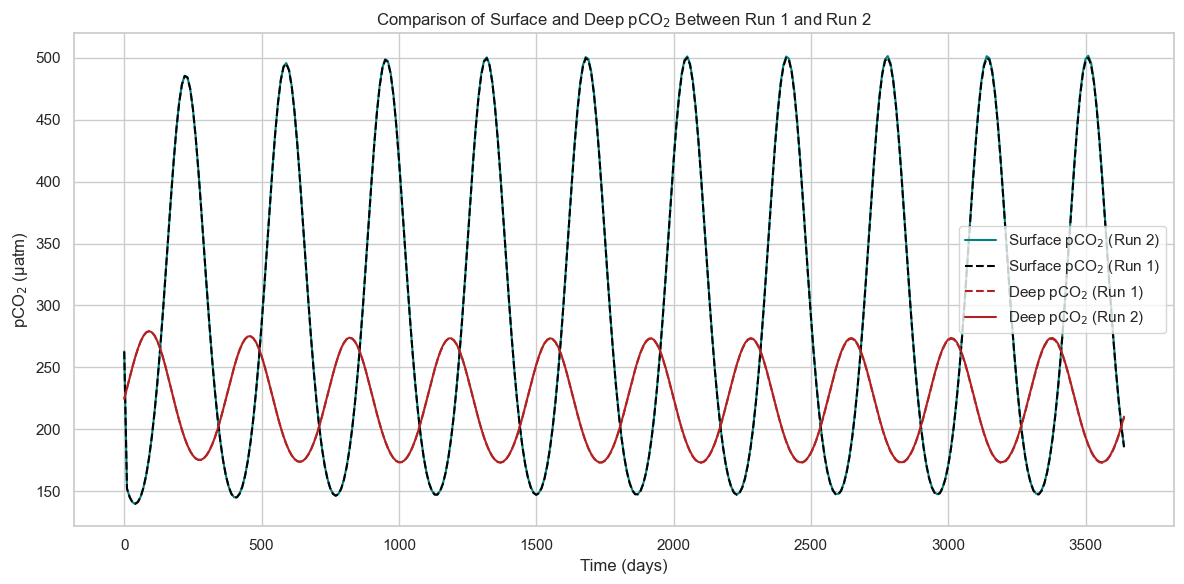

In [23]:
plt.figure(figsize=(12, 6))

# Surface pCO₂
plt.plot(output_df_2['time'], output_df_2['pCO2_surface'], label='Surface pCO$_2$ (Run 2)', color='teal')
plt.plot(output_df_1['time'], output_df_1['pCO2_surface'], label='Surface pCO$_2$ (Run 1)', color='black', linestyle='--')

# Deep pCO₂
plt.plot(output_df_1['time'], output_df_1['pCO2_deep'], label='Deep pCO$_2$ (Run 1)', color='firebrick', linestyle='--')
plt.plot(output_df_2['time'], output_df_2['pCO2_deep'], label='Deep pCO$_2$ (Run 2)', color='firebrick')

plt.xlabel("Time (days)")
plt.ylabel("pCO$_2$ (μatm)")
plt.title("Comparison of Surface and Deep pCO$_2$ Between Run 1 and Run 2")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


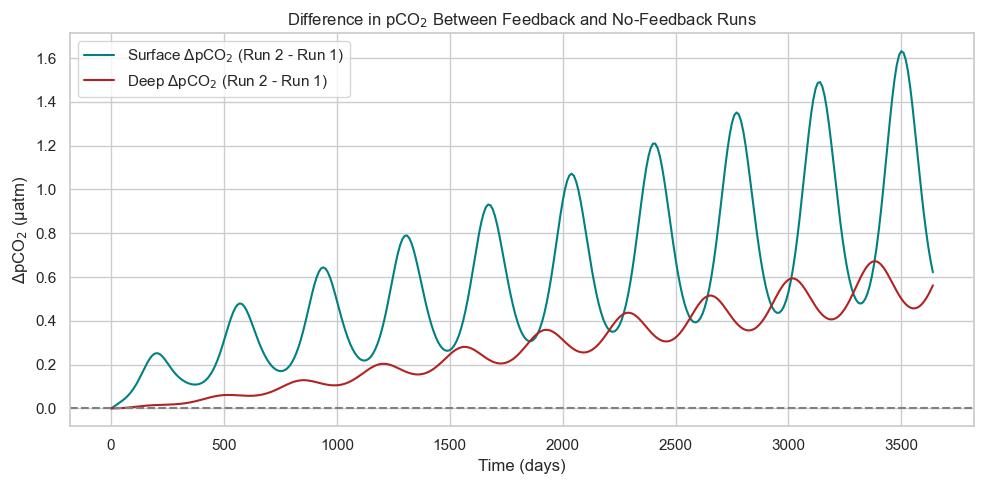

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(output_df_2['time'], output_df_2['pCO2_surface'] - output_df_1['pCO2_surface'], label='Surface ΔpCO$_2$ (Run 2 - Run 1)', color='teal')
plt.plot(output_df_2['time'], output_df_2['pCO2_deep'] - output_df_1['pCO2_deep'], label='Deep ΔpCO$_2$ (Run 2 - Run 1)', color='firebrick')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Time (days)")
plt.ylabel("ΔpCO$_2$ (µatm)")
plt.title("Difference in pCO$_2$ Between Feedback and No-Feedback Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


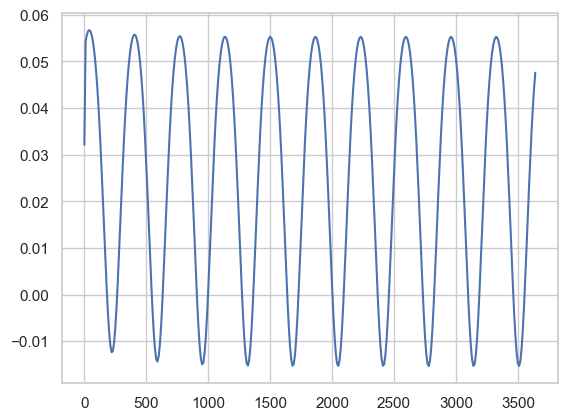

In [25]:
plt.plot(output_df_1['time'], output_df_1['J_air'])


# SOCAT Observational Data

In [26]:
# Open the dataset
ds = xr.open_dataset(rawDir + "SOCATv2024_tracks_gridded_monthly.nc")


In [27]:
# Print general information about the dataset
print(ds)

# List all variables
print("Variables:\n", list(ds.data_vars))

# View dimensions
print("Dimensions:\n", ds.dims)

# View global attributes
print("Global Attributes:\n", ds.attrs)


<xarray.Dataset> Size: 5GB
Dimensions:                (xlon: 360, ylat: 180, tmnth: 648, bnds: 2)
Coordinates:
  * xlon                   (xlon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * ylat                   (ylat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * tmnth                  (tmnth) datetime64[ns] 5kB 1970-01-16T12:00:00 ......
Dimensions without coordinates: bnds
Data variables: (12/25)
    tmnth_bnds             (tmnth, bnds) datetime64[ns] 10kB ...
    count_ncruise          (tmnth, ylat, xlon) float64 336MB ...
    fco2_count_nobs        (tmnth, ylat, xlon) float64 336MB ...
    fco2_ave_weighted      (tmnth, ylat, xlon) float32 168MB ...
    fco2_ave_unwtd         (tmnth, ylat, xlon) float32 168MB ...
    fco2_min_unwtd         (tmnth, ylat, xlon) float32 168MB ...
    ...                     ...
    salinity_min_unwtd     (tmnth, ylat, xlon) float32 168MB ...
    salinity_max_unwtd     (tmnth, ylat, xlon) float32 168MB ...
    salinity_std_weighted  (tmnth, ylat, 

In [ ]:
#lat_range = slice(57, 72)   # South of Kristiansand to North Cape
#lon_range = slice(4, 31)    # West of Bergen to Barents Sea

lat_range = slice(60, 68) # increase latitude slightly south for more Skagerrak coverage
lon_range = slice(-10, 10)  # Include parts of the Norwegian Sea

# Extract relevant variables and region
subset = ds[[
    'sst_ave_weighted', 
    'salinity_ave_weighted', 
    'fco2_ave_weighted'
]].sel(ylat=lat_range, xlon=lon_range)

# Check dimensions
print(subset)


<xarray.Dataset> Size: 1MB
Dimensions:                (tmnth: 648, ylat: 8, xlon: 20)
Coordinates:
  * xlon                   (xlon) float64 160B -9.5 -8.5 -7.5 ... 7.5 8.5 9.5
  * ylat                   (ylat) float64 64B 60.5 61.5 62.5 ... 65.5 66.5 67.5
  * tmnth                  (tmnth) datetime64[ns] 5kB 1970-01-16T12:00:00 ......
Data variables:
    sst_ave_weighted       (tmnth, ylat, xlon) float32 415kB ...
    salinity_ave_weighted  (tmnth, ylat, xlon) float32 415kB ...
    fco2_ave_weighted      (tmnth, ylat, xlon) float32 415kB ...
Attributes:
    history:      PyFerret V7.63 (optimized) 29-Apr-24
    Conventions:  CF-1.6
    title:        SOCAT gridded v2024 Monthly 1x1 degree gridded dataset
    summary:      Surface Ocean Carbon Atlas (SOCAT) Gridded (binned) SOCAT o...
    references:   http://www.socat.info/
    SOCAT_Notes:  SOCAT gridded v2024 29-Apr-2024
    caution:      NO INTERPOLATION WAS PERFORMED. SIGNIFICANT BIASES ARE PRES...


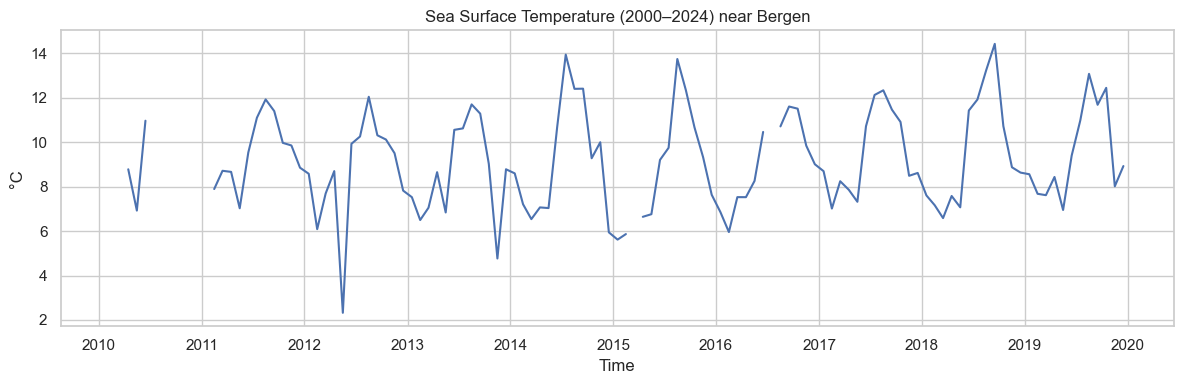

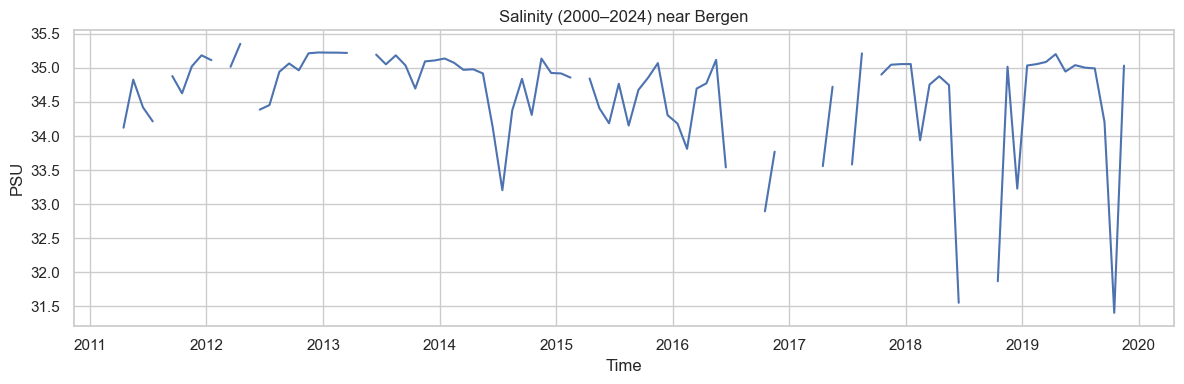

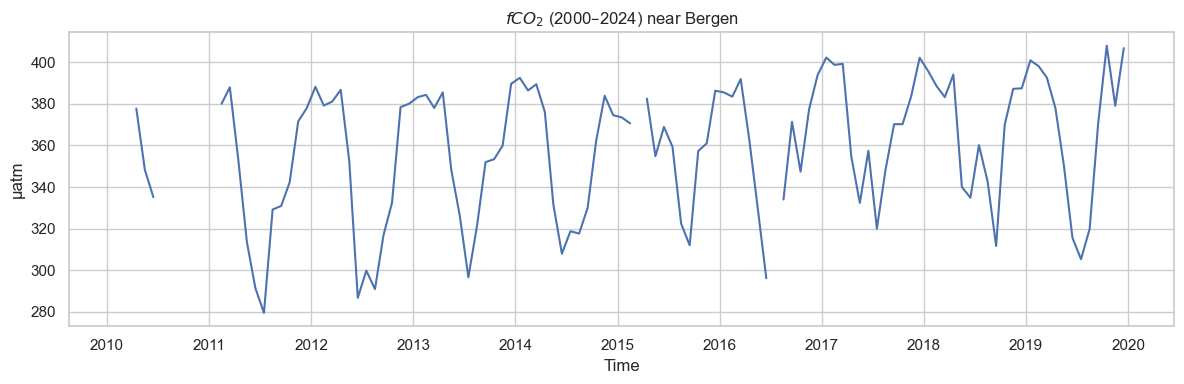

In [ ]:
# 2. Filter time range from 2000 to 2024
subset = subset.sel(tmnth=slice("2010-01-01", "2019-12-31"))

# 3. Compute spatial average
mean_data = subset.mean(dim=['xlon', 'ylat'], skipna=True)

# 4. Plot time series for each variable
def plot_time_series(var, label, ylabel):
    plt.figure(figsize=(12, 4))
    plt.plot(mean_data.tmnth, mean_data[var], label=label)
    plt.title(f"{label} (2000–2024) near Bergen")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot each variable
plot_time_series('sst_ave_weighted', 'Sea Surface Temperature', '°C')
plot_time_series('salinity_ave_weighted', 'Salinity', 'PSU')
plot_time_series('fco2_ave_weighted', r'$fCO_2$', 'µatm')


In [30]:
# Combine both observed series into a single DataFrame
obs_df = pd.DataFrame({
    'T': mean_data['sst_ave_weighted'].values,
    'S': mean_data['salinity_ave_weighted'].values
}, index=mean_data['tmnth'].values)

# Drop rows with any NaNs
obs_df = obs_df.dropna()

# Extract cleaned values and time
obs_T = obs_df['T'].values
obs_S = obs_df['S'].values
obs_time = pd.to_datetime(obs_df.index)

print(obs_df['T'].describe())
print(obs_df['S'].describe())


count    86.000000
mean      9.116103
std       2.063546
min       4.767095
25%       7.527761
50%       8.818583
75%      10.654057
max      13.944927
Name: T, dtype: float64
count    86.000000
mean     34.605255
std       0.777801
min      31.404343
25%      34.380067
50%      34.910347
75%      35.056140
max      35.353031
Name: S, dtype: float64


# Manual Fitting

In [31]:
obs_start = obs_time.min()
obs_end = obs_time.max()

# Generate time range with 10-day steps
model_time_10d = pd.date_range(start=obs_start, end=obs_end, freq='10D')

# Convert to days since 2000-01-01 for odeint
times = (model_time_10d - pd.Timestamp("2000-01-01")).days.values
# Model parameters
params = {
    'tau_1T': 0.14, 'tau_1S': 0.11, 'tau_2': 0.19,
    'A_1T': 7, 'A_1S': 13, # NEW
    'A_2T': 5.21,
    'phi_1T': -0.63, 'phi_1S': np.pi / 4, 'phi_2T': np.pi / 2,
    'T1_star': 10, 'T2_star': 10, # NEW
    'S1_star': 20, 'S2_star': 34, #NEW
    'h1': 50, 'h2': 100,
    'KD': 0.1, 'NCP': 0.02, 'PICPOC': 0.04, 'Remin': 0.9,
    'K_air': 0.02, 'alpha_CO2': 0.01, 'pCO2_atm': 423.57
}

# Initial state variables: [T1, T2, S1, S2, DIC1, DIC2, TA1, TA2]
state0 = [15, 10, 35, 34, 2000, 2100, 2300, 2400]

In [32]:
output = odeint(model, state0, times, args=(params,))
output_df = pd.DataFrame(output, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
output_df['time'] = times

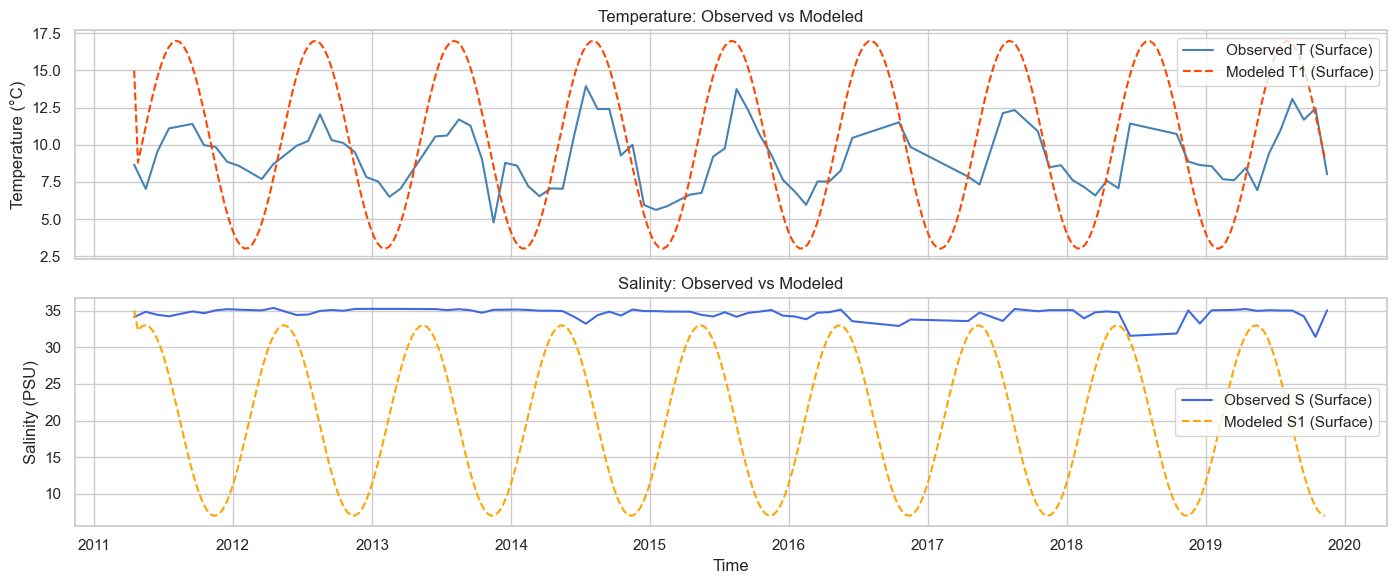

In [33]:
# Convert model time (days) to datetime
model_start_date = pd.Timestamp("2000-01-01")
output_df['date'] = model_start_date + pd.to_timedelta(output_df['time'], unit='D')

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# --- Temperature Plot ---
axes[0].plot(obs_df.index, obs_df['T'], label='Observed T (Surface)', color='steelblue')
axes[0].plot(output_df['date'], output_df['T1'], '--', label='Modeled T1 (Surface)', color='orangered')
#axes[0].plot(output_df['date'], output_df['T2'], '--', label='Modeled T2 (Deep)', color='darkred')
axes[0].set_ylabel("Temperature (°C)")
axes[0].set_title("Temperature: Observed vs Modeled")
axes[0].legend()
axes[0].grid(True)

# --- Salinity Plot ---
axes[1].plot(obs_df.index, obs_df['S'], label='Observed S (Surface)', color='royalblue')
axes[1].plot(output_df['date'], output_df['S1'], '--', label='Modeled S1 (Surface)', color='orange')
#axes[1].plot(output_df['date'], output_df['S2'], '--', label='Modeled S2 (Deep)', color='darkorange')
axes[1].set_ylabel("Salinity (PSU)")
axes[1].set_title("Salinity: Observed vs Modeled")
axes[1].legend()
axes[1].grid(True)

plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Unconstrained Fitting

In [34]:
# Wrap your model to allow parameter passing
def run_model(params_vector, times, state0, param_template, param_keys):
    # Map vector to param dict
    p = param_template.copy()
    p.update({k: v for k, v in zip(param_keys, params_vector)})

    # Run model
    result = odeint(model, state0, times, args=(p,))
    return result  # shape: (len(times), 8)


In [35]:
def objective_function(params_vector):
    result = run_model(params_vector, times, state0, param_template, param_keys)
    model_T1 = result[:, 0]  # T1
    model_S1 = result[:, 2]  # S1

    # Compute squared error
    error_T = model_T1 - obs_T
    error_S = model_S1 - obs_S

    # RMSE or sum of squares
    return np.sum(error_T**2) + np.sum(error_S**2)


In [36]:
param_template = params.copy()
param_keys = [
    'A_1T', 'A_1S',             # Seasonal amplitudes
    'tau_1T', 'tau_1S',         # Surface response timescales
    'T1_star', 'S1_star'        # Mean seasonal target values
]

initial_guess = [params[k] for k in param_keys]

bounds = [
    (5, 20),      # A_1T (seasonal amplitude in °C)
    (0, 15),       # A_1S (salinity amplitude)
    (10, 1000),   # tau_1T (restoring time in days)
    (10, 1000),   # tau_1S
    (5, 15),      # T1_star (°C)
    (25, 35)      # S1_star (PSU)
]

result = minimize(objective_function, initial_guess, method='Nelder-Mead')


ValueError: operands could not be broadcast together with shapes (314,) (86,) 

In [ ]:
print("Optimized Parameters:")
for k, v in zip(param_keys, result.x):
    print(f"{k}: {v:.4f}")


Optimized Parameters:
A_1T: 14.4800
A_1S: -1.4600
tau_1T: 0.1400
tau_1S: 0.1100


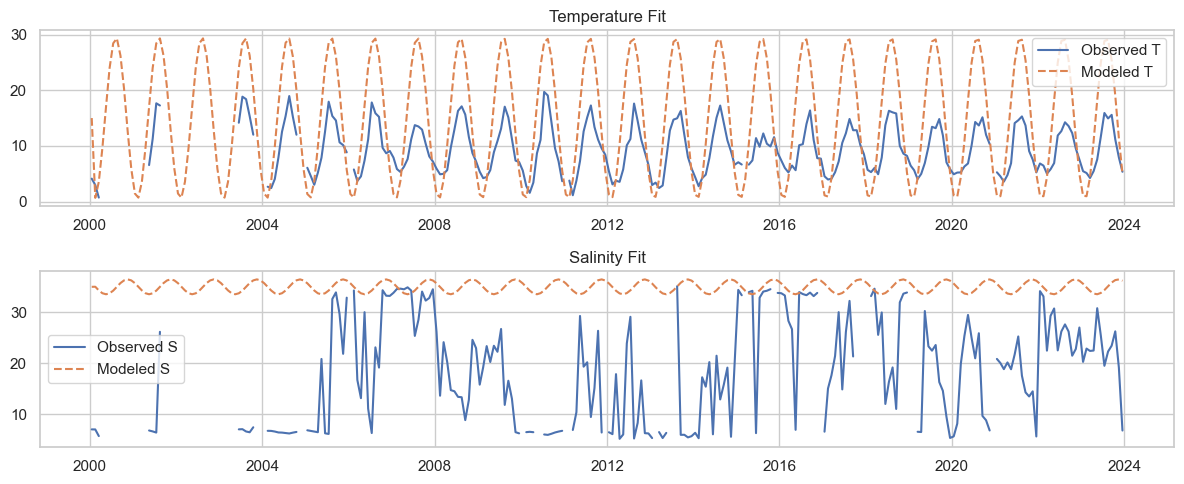

In [ ]:
# After fitting:
result_model = run_model(result.x, times, state0, param_template, param_keys)
model_T1 = result_model[:, 0]
model_S1 = result_model[:, 2]

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(obs_time, obs_T, label="Observed T")
plt.plot(obs_time, model_T1, label="Modeled T", linestyle='--')
plt.legend()
plt.title("Temperature Fit")

plt.subplot(2, 1, 2)
plt.plot(obs_time, obs_S, label="Observed S")
plt.plot(obs_time, model_S1, label="Modeled S", linestyle='--')
plt.legend()
plt.title("Salinity Fit")
plt.tight_layout()
plt.show()


# GLODAP Data

In [37]:
df_glodap = pd.read_csv(rawDir + "GLODAPv2.2023_Merged_Master_File.csv", low_memory=False)


In [38]:
# Basic structure
print(df_glodap.shape)             # Number of rows and columns
print(df_glodap.columns.tolist())  # List of column names

# set all -9999 to NaN
df_glodap.replace(-9999, np.nan, inplace=True)

(1402829, 109)
['G2expocode', 'G2cruise', 'G2station', 'G2region', 'G2cast', 'G2year', 'G2month', 'G2day', 'G2hour', 'G2minute', 'G2latitude', 'G2longitude', 'G2bottomdepth', 'G2maxsampdepth', 'G2bottle', 'G2pressure', 'G2depth', 'G2temperature', 'G2theta', 'G2salinity', 'G2salinityf', 'G2salinityqc', 'G2sigma0', 'G2sigma1', 'G2sigma2', 'G2sigma3', 'G2sigma4', 'G2gamma', 'G2oxygen', 'G2oxygenf', 'G2oxygenqc', 'G2aou', 'G2aouf', 'G2nitrate', 'G2nitratef', 'G2nitrateqc', 'G2nitrite', 'G2nitritef', 'G2silicate', 'G2silicatef', 'G2silicateqc', 'G2phosphate', 'G2phosphatef', 'G2phosphateqc', 'G2tco2', 'G2tco2f', 'G2tco2qc', 'G2talk', 'G2talkf', 'G2talkqc', 'G2fco2', 'G2fco2f', 'G2fco2temp', 'G2phts25p0', 'G2phts25p0f', 'G2phtsinsitutp', 'G2phtsinsitutpf', 'G2phtsqc', 'G2cfc11', 'G2pcfc11', 'G2cfc11f', 'G2cfc11qc', 'G2cfc12', 'G2pcfc12', 'G2cfc12f', 'G2cfc12qc', 'G2cfc113', 'G2pcfc113', 'G2cfc113f', 'G2cfc113qc', 'G2ccl4', 'G2pccl4', 'G2ccl4f', 'G2ccl4qc', 'G2sf6', 'G2psf6', 'G2sf6f', 'G2sf6

In [39]:
# North Atlantic region
lat_range = (60, 68)
lon_range = (-10, 10)
year_min = 2010
year_max = 2019

# Surface and deep cutoffs (example: ≤10 m = surface, >200 m = deep)
surface_depth_max = 10
deep_depth_min = 100


In [40]:
# Filter for region and time
df_filtered = df_glodap[
    (df_glodap['G2latitude'].between(*lat_range)) &
    (df_glodap['G2longitude'].between(*lon_range)) &
    (df_glodap['G2year'] >= year_min) &
    (df_glodap['G2year'] <= year_max)
]


In [41]:
# Surface layer (≤ 10 m)
df_surface = df_filtered[df_filtered['G2depth'] <= surface_depth_max]

# Deep layer (≥ 200 m)
df_deep = df_filtered[df_filtered['G2depth'] >= deep_depth_min]


In [42]:
vars_of_interest = ['G2year', 'G2month', 'G2latitude', 'G2longitude', 'G2depth',
                    'G2temperature', 'G2salinity', 'G2tco2', 'G2talk', 'G2fco2', 'G2phts25p0']

df_surface = df_surface[vars_of_interest].copy()
df_deep = df_deep[vars_of_interest].copy()


In [43]:
# Combine year + month into a proper datetime column (we'll use 15th of the month)
for df in [df_surface, df_deep]:
    df['date'] = pd.to_datetime(dict(year=df['G2year'], month=df['G2month'], day=15))

# Group and average for time series (monthly)
surface_monthly = df_surface.groupby('date').mean(numeric_only=True)
deep_monthly = df_deep.groupby('date').mean(numeric_only=True)

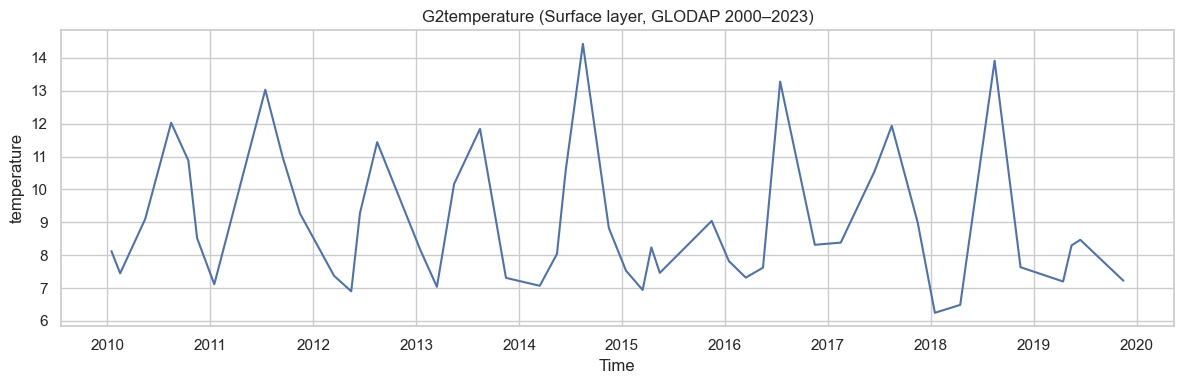

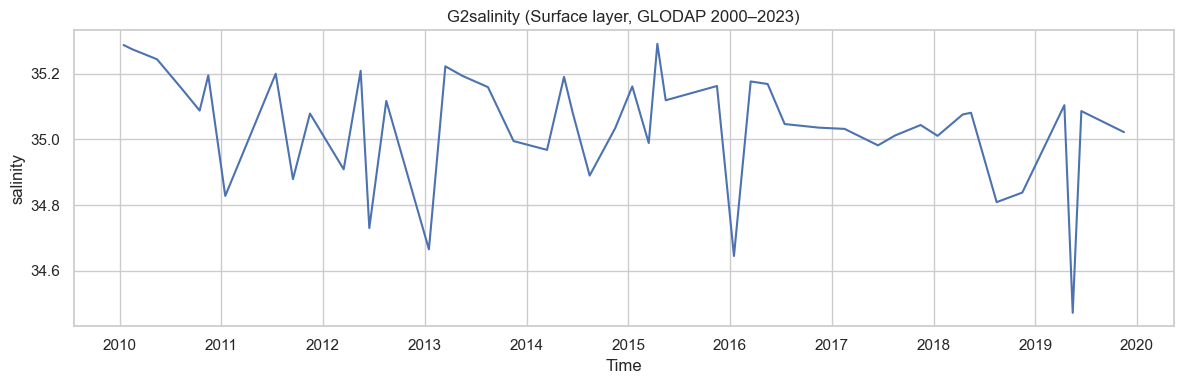

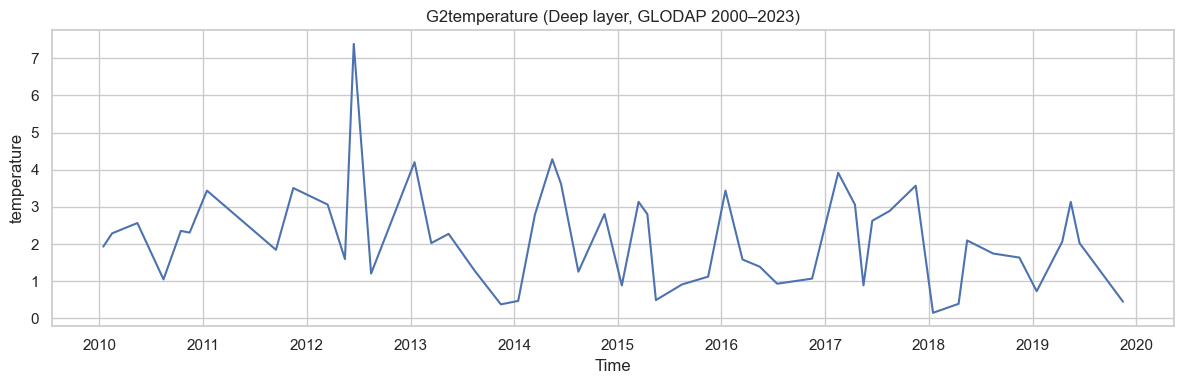

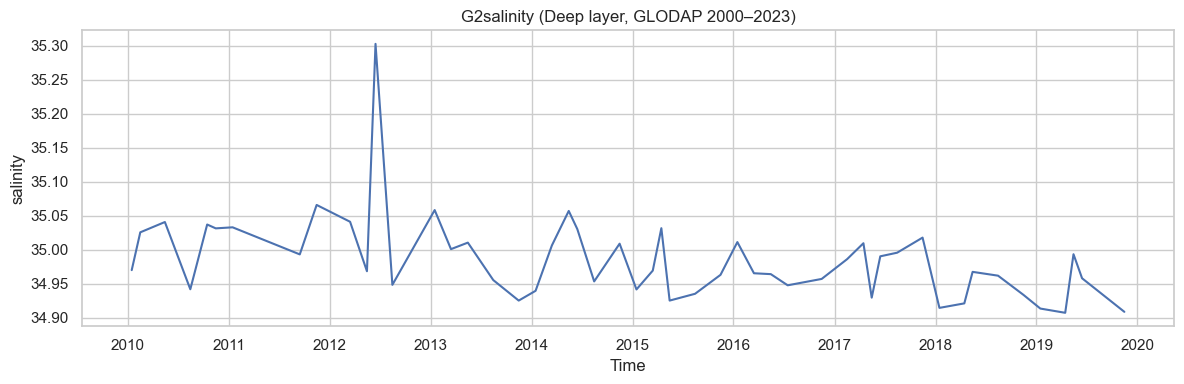

In [44]:
# Variables to plot (excluding metadata)
#plot_vars = ['G2temperature', 'G2salinity', 'G2tco2', 'G2talk', 'G2fco2', 'G2phts25p0']
plot_vars = ['G2temperature', 'G2salinity']
def plot_glodap_time_series(df, layer='Surface'):
    for var in plot_vars:
        plt.figure(figsize=(12, 4))
        plt.plot(df.index, df[var], label=var)
        plt.title(f"{var} ({layer} layer, GLODAP 2000–2023)")
        plt.xlabel("Time")
        plt.ylabel(var.replace('G2', ''))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Plot for surface and deep
plot_glodap_time_series(surface_monthly, layer='Surface')
plot_glodap_time_series(deep_monthly, layer='Deep')


# Manual Fitting with Glodap

In [45]:
# Use GLODAP date range for model time
obs_start = surface_monthly.index.min()
obs_end = surface_monthly.index.max()

# Generate time range with 10-day steps
model_time_10d = pd.date_range(start=obs_start, end=obs_end, freq='10D')

# Convert to days since 2000-01-01 for odeint
times = (model_time_10d - pd.Timestamp("2000-01-01")).days.values
# Model parameters
params = {
    'tau_1T': 0.14, 'tau_1S': 0.11, 'tau_2': 0.19,
    'A_1T': 2.5, 'A_1S': 0.1, # NEW
    'A_2T': 1.5,
    'phi_1T': -0.63, 'phi_1S': np.pi / 4+1, 'phi_2T': np.pi / 2,
    'T1_star': 8, 'T2_star': 1.5, # NEW
    'S1_star': 35, 'S2_star': 34.95, #NEW
    'h1': 50, 'h2': 100,
    'KD': 0.1, 'NCP': 0.02, 'PICPOC': 0.04, 'Remin': 0.9,
    'K_air': 0.02, 'alpha_CO2': 0.01, 'pCO2_atm': 423.57
}

# Initial state variables: [T1, T2, S1, S2, DIC1, DIC2, TA1, TA2]
state0 = [8, 1.5, 35, 34.95, 2000, 2100, 2300, 2400]

In [46]:
output = odeint(model, state0, times, args=(params,))
output_df = pd.DataFrame(output, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
output_df['time'] = times

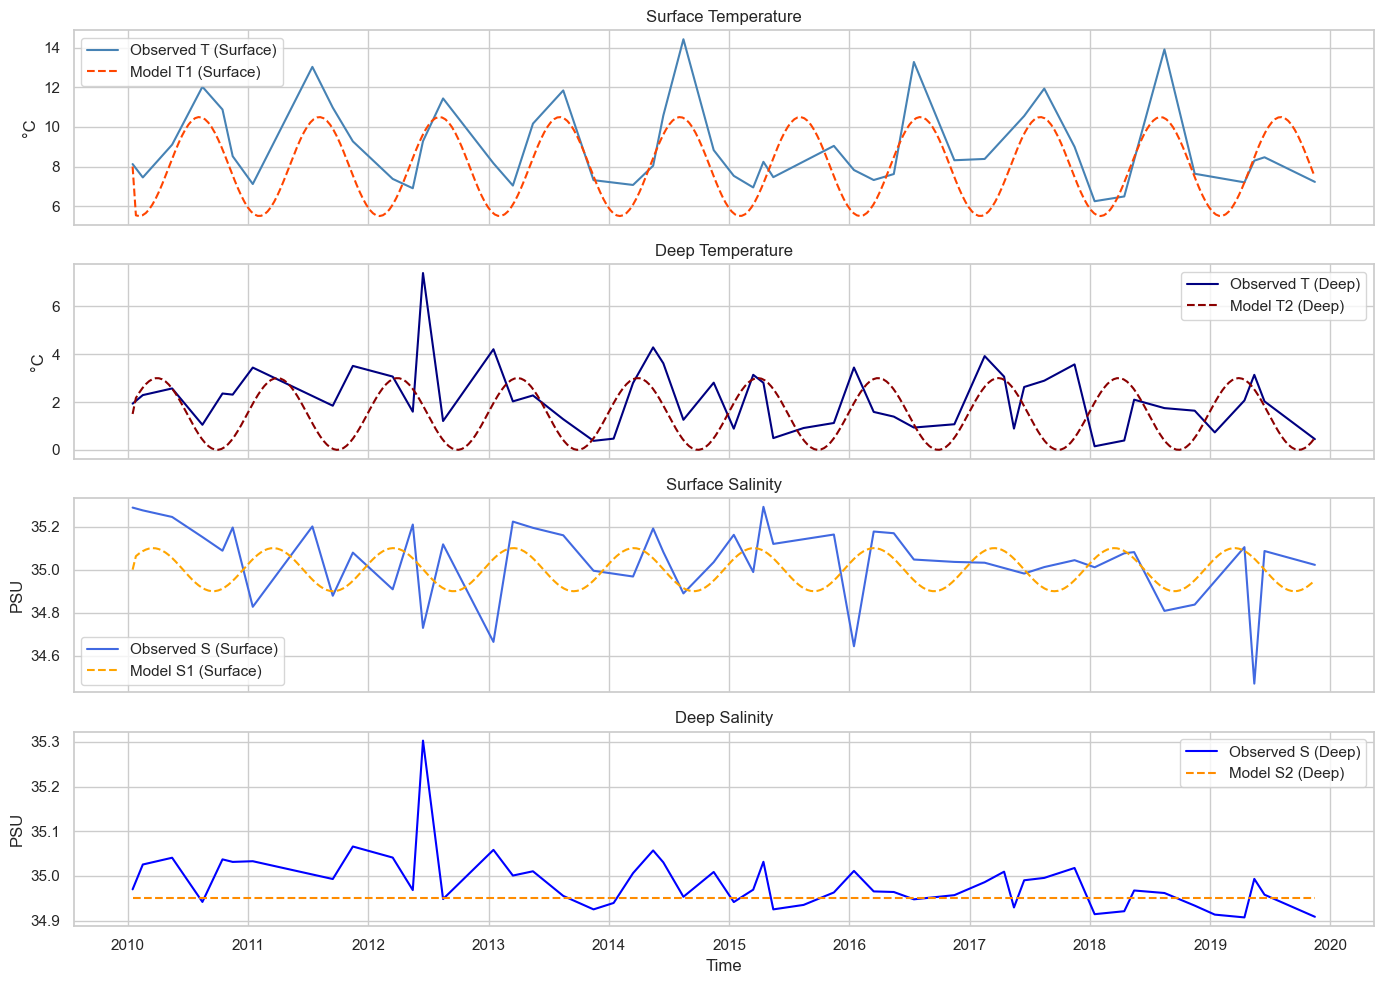

In [47]:
# Convert model time (days) to datetime
model_start_date = pd.Timestamp("2000-01-01")
output_df['date'] = model_start_date + pd.to_timedelta(output_df['time'], unit='D')

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# --- Surface Temperature ---
axes[0].plot(surface_monthly.index, surface_monthly['G2temperature'], label='Observed T (Surface)', color='steelblue')
axes[0].plot(output_df['date'], output_df['T1'], '--', label='Model T1 (Surface)', color='orangered')
axes[0].set_ylabel("°C")
axes[0].set_title("Surface Temperature")
axes[0].legend()
axes[0].grid(True)

# --- Deep Temperature ---
axes[1].plot(deep_monthly.index, deep_monthly['G2temperature'], label='Observed T (Deep)', color='navy')
axes[1].plot(output_df['date'], output_df['T2'], '--', label='Model T2 (Deep)', color='darkred')
axes[1].set_ylabel("°C")
axes[1].set_title("Deep Temperature")
axes[1].legend()
axes[1].grid(True)

# --- Surface Salinity ---
axes[2].plot(surface_monthly.index, surface_monthly['G2salinity'], label='Observed S (Surface)', color='royalblue')
axes[2].plot(output_df['date'], output_df['S1'], '--', label='Model S1 (Surface)', color='orange')
axes[2].set_ylabel("PSU")
axes[2].set_title("Surface Salinity")
axes[2].legend()
axes[2].grid(True)

# --- Deep Salinity ---
axes[3].plot(deep_monthly.index, deep_monthly['G2salinity'], label='Observed S (Deep)', color='blue')
axes[3].plot(output_df['date'], output_df['S2'], '--', label='Model S2 (Deep)', color='darkorange')
axes[3].set_ylabel("PSU")
axes[3].set_title("Deep Salinity")
axes[3].legend()
axes[3].grid(True)

# Final layout
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Unconstrained Fitting

In [48]:
# Join and clean observed data
obs_df = pd.DataFrame({
    'T1_obs': surface_monthly['G2temperature'],
    'S1_obs': surface_monthly['G2salinity'],
    'T2_obs': deep_monthly['G2temperature'],
    'S2_obs': deep_monthly['G2salinity']
}).dropna()

obs_time = obs_df.index
obs_days = (obs_time - pd.Timestamp("2000-01-01")).days.values

param_template = params.copy()

## Fit Temperature

In [49]:
param_keys_T = ['A_1T', 'A_2T', 'T1_star', 'T2_star', 'tau_1T', 'tau_2', 'phi_1T']


In [50]:
# Wrap your model to allow parameter passing
def run_model(params_vector, times, state0, param_template, param_keys):
    # Map vector to param dict
    p = param_template.copy()
    p.update({k: v for k, v in zip(param_keys, params_vector)})

    # Run model
    result = odeint(model, state0, times, args=(p,))
    return result  # shape: (len(times), 8)


In [51]:
def objective_temp(params_vector):
    p = param_template.copy()
    p.update({k: v for k, v in zip(param_keys_T, params_vector)})
    result = run_model(params_vector, times, state0, param_template, param_keys_T)

    model_T1 = interp1d(times, result[:, 0], kind='linear', fill_value='extrapolate')(obs_days)
    model_T2 = interp1d(times, result[:, 1], kind='linear', fill_value='extrapolate')(obs_days)

    err_T1 = model_T1 - obs_df['T1_obs'].values
    err_T2 = model_T2 - obs_df['T2_obs'].values
    return np.sum(err_T1**2 + err_T2**2)


In [52]:
initial_T = [params[k] for k in param_keys_T]
result_T = minimize(objective_temp, initial_T, method='Nelder-Mead')


In [53]:
print("Optimized Parameters:")
for k, v in zip(param_keys_T, result_T.x):
    print(f"{k}: {v:.4f}")


Optimized Parameters:
A_1T: 2.5971
A_2T: 0.4009
T1_star: 9.0509
T2_star: 2.2066
tau_1T: 0.1369
tau_2: 0.1674
phi_1T: -0.8688


In [54]:
# After fitting:
result_model = run_model(result_T.x, times, state0, param_template, param_keys)
model_T1 = interp1d(times, result_model[:, 0], kind='linear', fill_value='extrapolate')(obs_days)
model_T2 = interp1d(times, result_model[:, 1], kind='linear', fill_value='extrapolate')(obs_days)

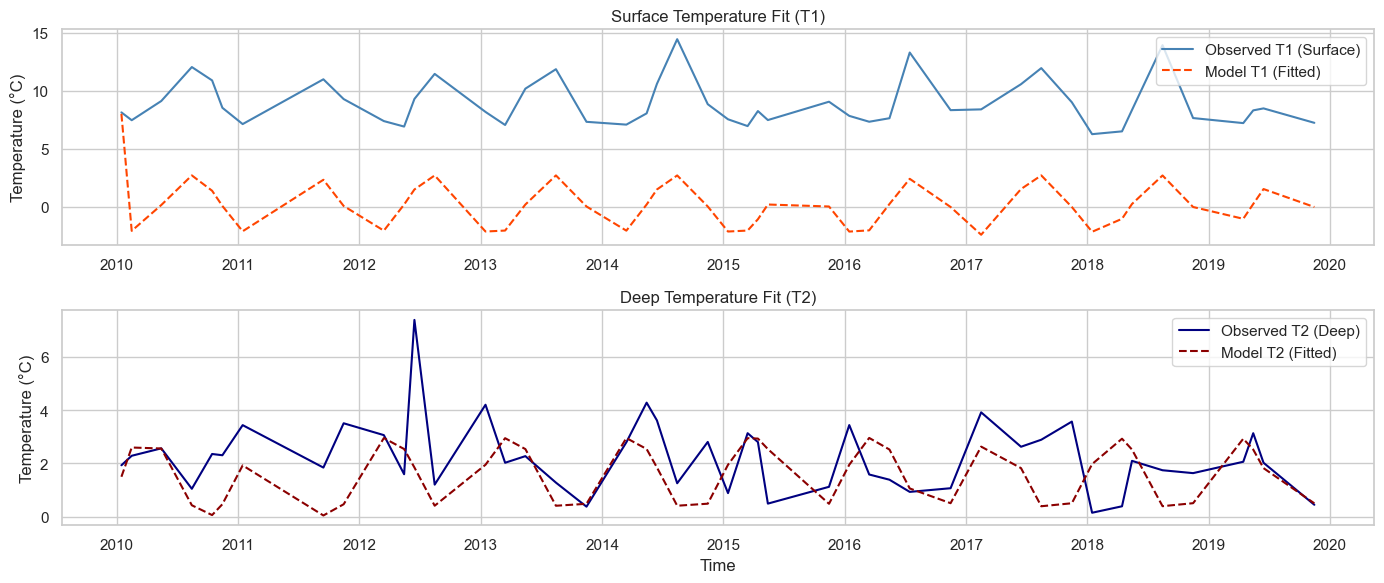

In [55]:
plt.figure(figsize=(14, 6))

# --- Surface Temperature ---
plt.subplot(2, 1, 1)
plt.plot(obs_time, obs_df['T1_obs'], label='Observed T1 (Surface)', color='steelblue')
plt.plot(obs_time, model_T1, '--', label='Model T1 (Fitted)', color='orangered')
plt.ylabel("Temperature (°C)")
plt.title("Surface Temperature Fit (T1)")
plt.legend()
plt.grid(True)

# --- Deep Temperature ---
plt.subplot(2, 1, 2)
plt.plot(obs_time, obs_df['T2_obs'], label='Observed T2 (Deep)', color='navy')
plt.plot(obs_time, model_T2, '--', label='Model T2 (Fitted)', color='darkred')
plt.ylabel("Temperature (°C)")
plt.title("Deep Temperature Fit (T2)")
plt.legend()
plt.grid(True)

plt.xlabel("Time")
plt.tight_layout()
plt.show()

## Fit Salinity

In [56]:
param_keys_S = ['A_1S', 'S1_star', 'S2_star', 'tau_1S', 'tau_2', 'phi_1S']


In [57]:
def objective_salin(params_vector):
    p = param_template.copy()
    p.update({k: v for k, v in zip(param_keys_S, params_vector)})
    result = run_model(params_vector, times, state0, param_template, param_keys_S)

    model_S1 = interp1d(times, result[:, 2], kind='linear', fill_value='extrapolate')(obs_days)
    model_S2 = interp1d(times, result[:, 3], kind='linear', fill_value='extrapolate')(obs_days)

    err_S1 = model_S1 - obs_df['S1_obs'].values
    err_S2 = model_S2 - obs_df['S2_obs'].values
    return np.sum(err_S1**2 + err_S2**2)


In [58]:
initial_S = [params[k] for k in param_keys_S]
result_S = minimize(objective_salin, initial_S, method='Nelder-Mead')


In [59]:
print("Optimized Parameters:")
for k, v in zip(param_keys_S, result_S.x):
    print(f"{k}: {v:.4f}")

Optimized Parameters:
A_1S: 0.0366
S1_star: 35.0292
S2_star: 34.9903
tau_1S: 0.1344
tau_2: 0.2837
phi_1S: 0.8489


## Combined Fit

In [60]:
param_keys_combined = list(set(param_keys_T + param_keys_S))  # remove duplicates
initial_combined = [params[k] for k in param_keys_combined]


In [61]:
def objective_all(params_vector):
    p = param_template.copy()
    p.update({k: v for k, v in zip(param_keys_combined, params_vector)})
    result = run_model(params_vector, times, state0, param_template, param_keys_combined)

    model_T1 = interp1d(times, result[:, 0], kind='linear', fill_value='extrapolate')(obs_days)
    model_T2 = interp1d(times, result[:, 1], kind='linear', fill_value='extrapolate')(obs_days)
    model_S1 = interp1d(times, result[:, 2], kind='linear', fill_value='extrapolate')(obs_days)
    model_S2 = interp1d(times, result[:, 3], kind='linear', fill_value='extrapolate')(obs_days)

    err_T1 = model_T1 - obs_df['T1_obs'].values
    err_T2 = model_T2 - obs_df['T2_obs'].values
    err_S1 = model_S1 - obs_df['S1_obs'].values
    err_S2 = model_S2 - obs_df['S2_obs'].values
    return np.sum(err_T1**2 + err_T2**2 + err_S1**2 + err_S2**2)


In [62]:
result_combined = minimize(objective_all, initial_combined, method='Nelder-Mead')

In [63]:
print("Optimized Parameters:")
for k, v in zip(param_keys_combined, result_combined.x):
    print(f"{k}: {v:.4f}")

Optimized Parameters:
T2_star: 2.2065
T1_star: 9.0509
A_1S: 0.0366
A_2T: 0.4008
phi_1T: -0.8688
S2_star: 34.9902
tau_1S: 0.1777
phi_1S: 0.8378
A_1T: 2.5972
tau_2: 0.2220
tau_1T: 0.1389
S1_star: 35.0293


In [64]:
# Run final model
result_model = run_model(result.x, times, state0, param_template, param_keys)
output_df = pd.DataFrame(result_model, columns=['T1', 'T2', 'S1', 'S2', 'DIC1', 'DIC2', 'TA1', 'TA2'])
output_df['date'] = model_start_date + pd.to_timedelta(times, unit='D')

# Plot without interpolation
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Temperature plots
axes[0].plot(obs_time, obs_df['T1_obs'], label='Obs T1 (Surface)', color='steelblue')
axes[0].plot(output_df['date'], output_df['T1'], '--', label='Model T1', color='orangered')
axes[0].set_title("Surface Temperature")
axes[0].legend(); axes[0].grid(True)

axes[1].plot(obs_time, obs_df['T2_obs'], label='Obs T2 (Deep)', color='navy')
axes[1].plot(output_df['date'], output_df['T2'], '--', label='Model T2', color='darkred')
axes[1].set_title("Deep Temperature")
axes[1].legend(); axes[1].grid(True)

# Salinity plots
axes[2].plot(obs_time, obs_df['S1_obs'], label='Obs S1 (Surface)', color='royalblue')
axes[2].plot(output_df['date'], output_df['S1'], '--', label='Model S1', color='orange')
axes[2].set_title("Surface Salinity")
axes[2].legend(); axes[2].grid(True)

axes[3].plot(obs_time, obs_df['S2_obs'], label='Obs S2 (Deep)', color='blue')
axes[3].plot(output_df['date'], output_df['S2'], '--', label='Model S2', color='darkorange')
axes[3].set_title("Deep Salinity")
axes[3].legend(); axes[3].grid(True)

plt.xlabel("Time")
plt.tight_layout()
plt.show()


NameError: name 'result' is not defined